# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19



# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.0.0


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform): 
        def get_images(class_name):   
            # the argument 'image_dir' will be a dict which will have path for the three class directories 
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]    
            print(f'Found {len(images)} {class_name} samples')                                     
            return images
        
        # define empty dict to store images for the 3 different classes
        self.images = {}     
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:          
            # get the list of images for the class being iterated
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):        
        # returns the length of the dataset ie., no of images for all 3 classes
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):  
        class_name = random.choice(self.class_names)    
        
        # index can be out of bounds for some images of a class,
        # so we take the mod of the index with total no. of images in that class 
        index = index % len(self.images[class_name]) 
        
        image_name = self.images[class_name][index]
        
        # join the image_dir path and image name to get the full path of image
        image_path = os.path.join(self.image_dirs[class_name], image_name)  
        
        # convert the b&w to RGB since we are using ResNET18 that has pre-trained weights(trained on imagenet dataset) 
        # and inputs are defined (3 channels)
        image = Image.open(image_path).convert('RGB')  
        
        return self.transform(image), self.class_names.index(class_name)  

# Image Transformations

In [4]:
# transform objects are created for data augmentation of the images

# since we use pretrained resnet model we need to convert all images to the size the model expects
train_transform = torchvision.transforms.Compose([    
    torchvision.transforms.Resize(size = (224, 224)), 
    
    # h-flip of image helps the model to generalize better and doesn't make any difference for classification
    torchvision.transforms.RandomHorizontalFlip(),
    
    # convert to tensor so that image can be used in computation by PyTorch
    torchvision.transforms.ToTensor(),                 
    
    # normalize our input data in the same way that the imagenet dataset (used for training resnet18) was normalized
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [7]:
# we don't need to do RandomHorizontalFlip in test_transform since the test set is 
# kept close to real world data to be a more accurate representation of the performance of the models

test_transform = torchvision.transforms.Compose([     
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),                 
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [8]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

# call the function with training directories and train_transform
train_dataset = ChestXRayDataset(train_dirs, train_transform)    

Found 1311 normal samples
Found 1315 viral samples
Found 189 covid samples


In [9]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

# call the function with test directories and test_transform
test_dataset = ChestXRayDataset(test_dirs, test_transform)   

Found 30 normal samples
Found 30 viral samples
Found 30 covid samples


In [10]:
batch_size = 6

# dataloader for training samples. The indices are shuffled and the samples are not picked in sequence
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)   

# dataloader for test samples
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

# no. of batches that are created from train and test sets
print('No. of training batches', len(dl_train))
print('No. of test batches', len(dl_test))


No. of training batches 470
No. of test batches 15


# Data Visualization

In [11]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        # 1 row and 6 columns (so 6 images). Index for subplot starts from 1, so i+1
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])     
        
        # convert the image tensor (from dataloader) to numpy and transpose in a way where the first axis should be last one,
        # since in resnet the input is {channel, height, width}
        image = image.numpy().transpose((1, 2, 0))    
        
        mean = np.array([0.485, 0.456, 0.406])              
        std = np.array([0.229, 0.224, 0.225])
        
        # convert the image pixel values to original values before the normalization of images in the dataloaders
        image = image * std + mean                         
        image = np.clip(image, 0., 1.)
        
        # display image
        plt.imshow(image)                                   
        
        # prediction is displayed in green if it is correct, else in red
        col = 'green' if preds[i] == labels[i] else 'red' 
        
        # x-label for groud truth and y-label for prediction.
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()
        

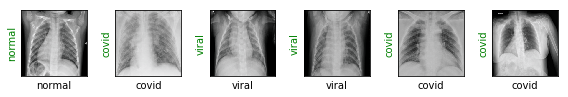

In [12]:
# fetch the next batch of 6 samples
images, labels = next(iter(dl_train))    

# since we don't have preds yet, pass labels 
show_images(images, labels, labels)          

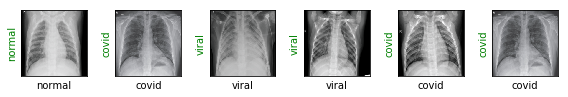

In [13]:
images, label = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [14]:
# use the pretrained weights from the Imagenet training
resnet18 = torchvision.models.resnet18(pretrained=True)  
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [15]:
# since there are only 3 classes to classify (normal,viral,covid), the out_features for the last fc is changed to 3
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)  
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5) 

In [16]:
def show_preds():
    # set model to evaluation mode, that turns off specific layers/parts of model when not training
    resnet18.eval()                       
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
   
    # get the indices that has the highest energy (the prediction), out of the 3 classes, for all images
    _, preds = torch.max(outputs, 1)     
    show_images(images, labels, preds)    

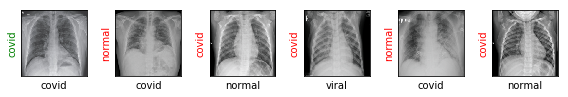

In [17]:
# model is not trained on our dataset yet, so it just uses the pretrained weights here
show_preds()                             

# Training the Model

In [18]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1/epochs}')
        print('='*20)
        
        train_loss = 0.
        
         # set model training to true, which turns on the specific layers/parts of model that were turned off during eval()
        resnet18.train()                      
        
        for train_step, (images, labels) in enumerate(dl_train):
            
            # make gradient buffers as 0
            optimizer.zero_grad()  
            
            outputs = resnet18(images)
            
            # apply cross entropy loss function on predicted and ground truth values
            loss = loss_fn(outputs, labels)    
            
            # backpropagate the loss
            loss.backward()             
            
            # perform gradient step to update model parameters
            optimizer.step()         
            
            train_loss += loss.item()
            
            # evaluate the model on the test set, once in every 20 steps (batches)
            if(train_step % 20 == 0):          
                print('Evaluating at step', train_step)
                
                # set accuracy to 0
                acc = 0.                      
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                # get validation loss for each step
                val_loss /= (val_step + 1)   
                
                # no. of samples which were predicted correct/total no. of samples in test set 
                acc = acc / len(test_dataset)   
                
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance condition is satisfied!')
                    return
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
            

Starting training..
Starting epoch 1.0
Evaluating at step 0
Val loss: 1.2342, Acc: 0.2222


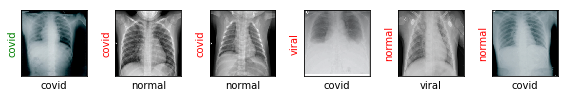

Evaluating at step 20
Val loss: 0.4641, Acc: 0.8889


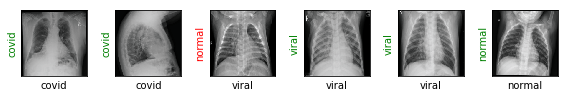

Evaluating at step 40
Val loss: 0.3297, Acc: 0.8556


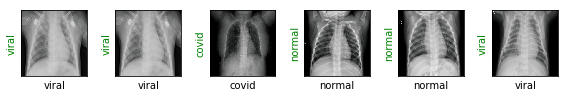

Evaluating at step 60
Val loss: 0.2238, Acc: 0.9000


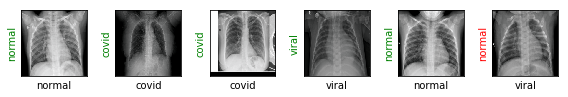

Evaluating at step 80
Val loss: 0.1536, Acc: 0.9111


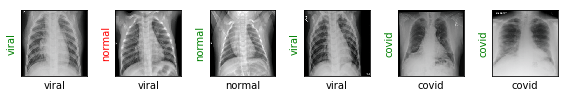

Evaluating at step 100
Val loss: 0.0820, Acc: 0.9889


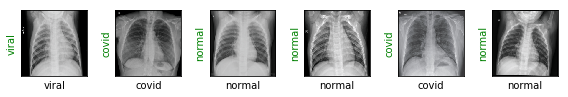

Performance condition is satisfied!


In [19]:
train(epochs=1)

# Final Results

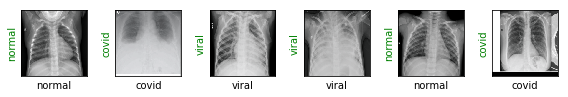

In [20]:
# the model is trained up to 100 steps and has achieved 98.89% accuracy, so it performs much better on the test set now
show_preds()         